# Reproducing Figure 8

In [1]:
###################
# Import packages #
###################

import arviz as az
import matplotlib.pylab as plt
import sys
sys.path.append('../code/')
from makeCorner import *
from scipy.special import gammainc
from scipy import interpolate
import numpy as np

In [2]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

In [16]:
from gwBackground import *

In [18]:
all_zs = np.linspace(0,10,200)
omg = OmegaGW_BBH(2.1,100.,all_zs,gridSize=(40,35))

In [19]:
rateData_MD = np.load('../input/delayedRateDataMD.npy', allow_pickle=True)[()]
formationRates_MD = rateData_MD['formationRates']
tdelays_MD = rateData_MD['tds']
zformation_MD = rateData_MD['zs']

In [20]:
dz = 0.01
zs = np.arange(0.,10.0,dz) # NOTE: should be same array as what was used to make the delayedRateDataMD.npy file

def R_norm_MD(zs, metMin_td, lambda_td, tdmin):
    fs = gammainc(0.84,(metMin_td**2.)*np.power(10.,0.3*zformation_MD))[...,None]
    weightedFormationRates_MD = formationRates_MD*fs

    dpdt = np.power(tdelays_MD,lambda_td)
    dpdt[tdelays_MD<tdmin] = 0.
    dpdt[tdelays_MD>13.5] = 0.
    mergerRate_MD = weightedFormationRates_MD.dot(dpdt)

    R = mergerRate_MD
    f = interpolate.interp1d(zs, R)
    norm = f(0.2)
    return R, norm

In [21]:
freqs = np.arange(10,1000,1)

In [22]:
data_CBC_GWB_O3 = az.from_netcdf("../data/O3_CBC_GWB_MD.cdf")
stacked_samples_O3 = data_CBC_GWB_O3.posterior.stack(draws=("chain", "draw"))

In [23]:
omg.setProbs_plPeak(np.median(stacked_samples_O3.mMin.data.flatten()),
                    np.median(stacked_samples_O3.mMax.data.flatten()),
                    np.median(stacked_samples_O3.alpha.data.flatten()),
                    np.median(stacked_samples_O3.mu_m1.data.flatten()),
                    np.median(stacked_samples_O3.sig_m1.data.flatten()),
                    np.median(10.**stacked_samples_O3.log_f_peak.data.flatten()),
                    np.median(stacked_samples_O3.bq.data.flatten()),
                    np.median(stacked_samples_O3.R20.data.flatten()), 
                    np.median(10.**stacked_samples_O3.log_dmMax.data.flatten()),
                    np.median(10.**stacked_samples_O3.log_dmMin.data.flatten()))

In [3]:
N=100
Zmax_array = np.linspace(-4, 0, N)
kappa_array = np.linspace(-10,0, N)
omega_array = np.zeros((N,N), dtype=np.ndarray)

In [4]:
from constants import H0
import scipy.integrate

In [ ]:
ligo_noise_asd = np.loadtxt("../mock_gwb_O5/AplusDesign.txt")[:,1] 
ligo_noise_psd = ligo_noise_asd**2
frequencies = np.loadtxt("../mock_gwb_O5/AplusDesign.txt")[:,0] 
ligo_noise_psd = np.interp(freqs, frequencies, ligo_noise_psd)[:np.size(frequencies)]

In [ ]:
def SNR(f, T, P1,P2,Omega):
    pre_factor = 3*H0**2/10/np.pi**2*np.sqrt(2*T)
    integrand = orf_interp**2*Omega**2/f**6/P1/P2
    integral = scipy.integrate.simpson(integrand, x=f)
    return pre_factor * np.sqrt(integral)

In [ ]:
Tobs = 365 * 24 * 3600 #seconds

In [ ]:
orf_12 = np.load("../mock_gwb_O5/ORF_HL.npy")
orf_12_freqs = np.load("../mock_gwb_O5/ORF_HL_freqs.npy")

In [ ]:
orf_interp = np.interp(freqs, orf_12_freqs, orf_12)

In [ ]:
SNRs = np.zeros((N,N))
for ii in range(N):
    for jj in range(N):
        SNRs[ii,jj] = SNR(freqs, Tobs, ligo_noise_psd, ligo_noise_psd,omega_array[ii,jj])

In [5]:
Z_mesh, kappa_mesh = np.meshgrid(Zmax_array, kappa_array)

In [6]:
from matplotlib import cm

<a list of 6 text.Text objects>

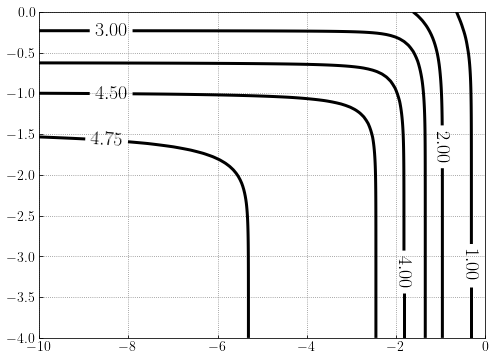

In [85]:
contours = plt.contour(kappa_mesh, Z_mesh,SNRs.T, [1,2,3,4,4.5,4.75], colors='k', linewidths = 3)
plt.clabel(contours, inline=True,fontsize=20)

In [86]:
SNR_flat = SNRs.flatten()

In [87]:
kappa_flat = np.array([kappa_array for ii in range(N)]).flatten()

In [88]:
Zmax_flat = np.array([np.ones(N)*Zmax_array[ii] for ii in range(N)]).flatten()

/tmp/ipykernel_5936/1171325461.py:48: UserWarning: linewidths is ignored by contourf
  contours_f = ax.contourf(kappa_mesh, Z_mesh,SNRs.T, [0,3,10], colors=[my_palette[0],my_palette[2]],alpha=0.7,linewidths = 2)


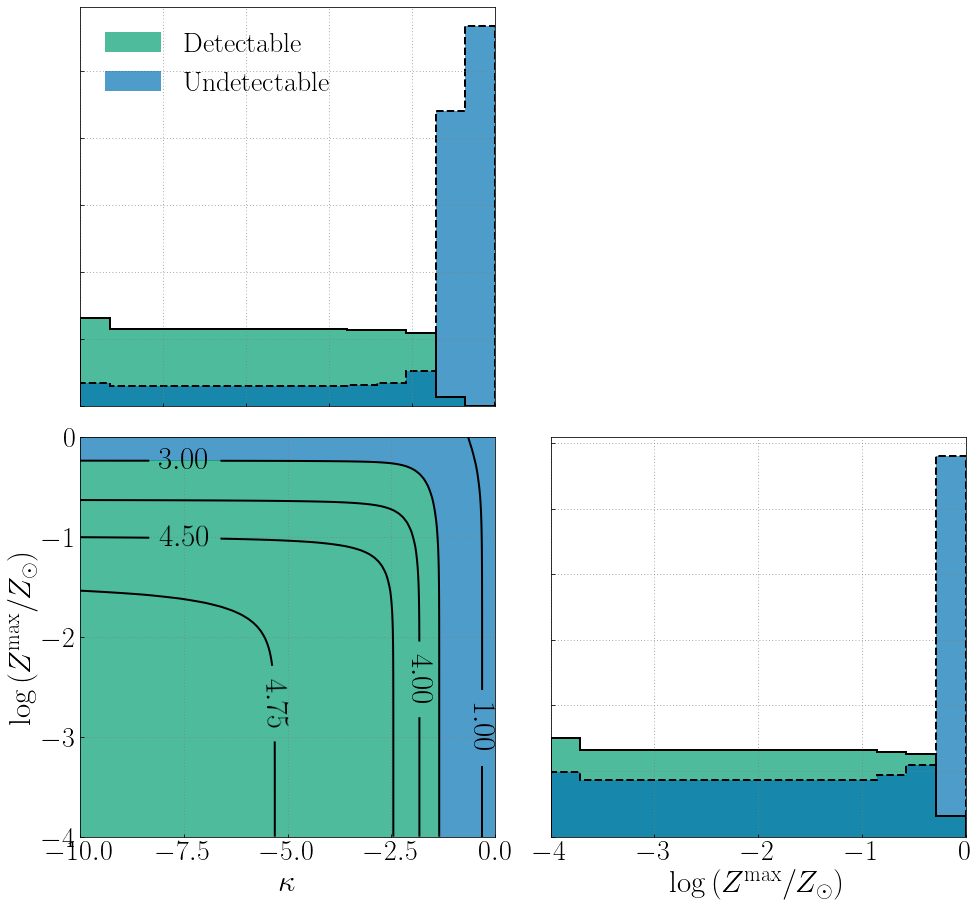

In [14]:
SNR_cut=3
bins=15

fig = plt.figure(figsize=(14,13))
       
ax = fig.add_subplot(2,2,int(1+(2+1)*0))
ax.grid(True,dashes=(1,3))
    
ax.set_xlim(kappa_array[0],kappa_array[-1])

ax.hist(kappa_flat[SNR_flat>=SNR_cut],bins=np.linspace(kappa_array[0],kappa_array[-1],bins),\
        color=my_palette[2],alpha=0.7,lw=2,density=True,zorder=0,rasterized=True, label="Detectable")
ax.hist(kappa_flat[SNR_flat>=SNR_cut],bins=np.linspace(kappa_array[0],kappa_array[-1],bins),\
        histtype='step',color='black',lw=2,density=True,zorder=2,rasterized=True)
ax.hist(kappa_flat[SNR_flat<SNR_cut],bins=np.linspace(kappa_array[0],kappa_array[-1],bins),\
        color=my_palette[0],alpha=0.7,lw=2,density=True,zorder=0,rasterized=True, label="Undetectable")
ax.hist(kappa_flat[SNR_flat<SNR_cut],bins=np.linspace(kappa_array[0],kappa_array[-1],bins),\
        histtype='step',color='black',ls='dashed',lw=2,density=True,zorder=0,rasterized=True)
ax.legend(fontsize = 28)
    
ax.set_yticklabels([])     

ax.set_xticklabels([])

ax = fig.add_subplot(2,2,int(1+(2+1)*1))
ax.grid(True,dashes=(1,3))
    
ax.set_xlim(Zmax_array[0],Zmax_array[-1])
        
ax.hist(Zmax_flat[SNR_flat>=SNR_cut],bins=np.linspace(Zmax_array[0],Zmax_array[-1],bins),\
        color=my_palette[2],alpha=0.7,lw=2,density=True,zorder=0,rasterized=True)
ax.hist(Zmax_flat[SNR_flat>=SNR_cut],bins=np.linspace(Zmax_array[0],Zmax_array[-1],bins),\
        histtype='step',color='black',lw=2,density=True,zorder=2,rasterized=True)
ax.hist(Zmax_flat[SNR_flat<SNR_cut],bins=np.linspace(Zmax_array[0],Zmax_array[-1],bins),\
        color=my_palette[0],alpha=0.7,lw=2,density=True,zorder=0,rasterized=True)
ax.hist(Zmax_flat[SNR_flat<SNR_cut],bins=np.linspace(Zmax_array[0],Zmax_array[-1],bins),\
        histtype='step',color='black',ls='dashed',lw=2,density=True,zorder=2,rasterized=True)

ax.set_yticklabels([])  

ax.set_xlabel(r"$\log  \left(Z^{\rm max}/Z_\odot\right)$",fontsize=31)
ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=28)

 
ax = fig.add_subplot(2,2,int(1+(2+1)*0 + (0+1)*2))

contours_f = ax.contourf(kappa_mesh, Z_mesh,SNRs.T, [0,3,10], colors=[my_palette[0],my_palette[2]],alpha=0.7,linewidths = 2)
contours = ax.contour(kappa_mesh, Z_mesh,SNRs.T, [1,3,4,4.5,4.75], colors='k', linewidths = 2)
ax.clabel(contours, inline=True,fontsize=31)

ax.set_xlabel(r"$\kappa$",fontsize=31)
ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=28)

ax.set_ylabel(r"$\log  \left(Z^{\rm max}/Z_\odot\right)$",fontsize=31)
ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=28)

ax.set_xlim(kappa_array[0],kappa_array[-1])
ax.set_ylim(Zmax_array[0],Zmax_array[-1])
ax.grid(True,dashes=(1,3))

plt.tight_layout()